# Data Mining within city bikeshare station

## Community Detection with bikeshare station

In [1]:
import random
import numpy as np
from scipy.stats import bernoulli
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp
import csv

In [2]:
def getCodToID():
  codToID = {}
  with open("/content/drive/MyDrive/Hackathon IA/Datasets/Brut Data/IdToCode.csv" , "r", newline="\n") as csvfile :
    csvreader = csv.reader(csvfile , delimiter = " ")
    for row in csvreader :
      codToID[int(row[0])] = int(row[1])
  
  return codToID

codToID = getCodToID()


def getAdjacencyMatrix():
  A = np.zeros(shape = (68 , 68) , dtype="int64")
  with open("/content/drive/MyDrive/Hackathon IA/Datasets/Brut Data/trip.csv" , "r") as csvfile :
    csvreader = csv.reader(csvfile)
    next(csvreader)
    for row in csvreader :
      if len(row) > 0:
        i = int(row[4])
        j = int(row[7])
        if i != 38 and i != 41 and j != 38 and j != 41:
          i = codToID[i]
          j = codToID[j]
          A[i][j] += 1
          A[j][i] += 1
    return A

A = getAdjacencyMatrix()



In [3]:
np.max(A)

9711

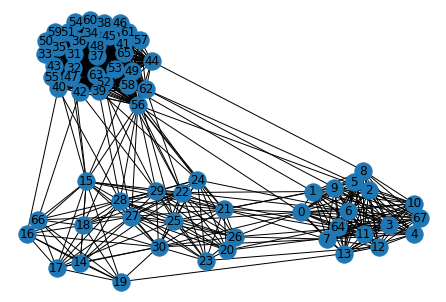

In [4]:
def getStrongAdjacencyMatrix(A):
  Aprime = A.copy()
  for i in range(A.shape[0]):
    for j in range(A.shape[1]):
      Aprime[i][j] = 1 if Aprime[i][j] else 0
  return Aprime

nx.drawing.nx_pylab.draw(nx.Graph(getStrongAdjacencyMatrix(A)) , with_labels=True)

In [5]:
# Entrée - Une matrice d'adjacence correspondant à une observation de notre modèle
# Sortie - Une liste de n labels
def algorithmeSpectral(A):
  # On trouve vecteurs et valeurs propres de A
  lmbd,v = sp.linalg.eigh(-A,eigvals = (1,1))
  #lmbd_ordered = np.sort(np.copy(lmbd))
  # On sélectionne le vecteur propre correspondant à la deuxième valeur propre
  #v2 = v[: , np.where(lmbd==lmbd_ordered[-2])[0]]
  label = np.zeros((A.shape[0]) , dtype="i1")
  # On classifie les sommet selon le signe du coefficient associé dans le vecteur propre
  for i in range(label.shape[0]):
    if v[i][0] > 0:
      label[i] = 1
  
  return label

import cvxpy as cp
import numpy


def algorithmeVershynin(A):
  n=A.shape[0]
  # On commence par obtenir la matrice B à partir de A
  lmbd = np.mean(A)
  B = A - lmbd*np.ones(A.shape)
  # Define and solve the CVXPY problem.
  # Create a symmetric matrix variable.
  x = cp.Variable((n , n) , symmetric = True)
  # The operator >> denotes matrix inequality
  constraints = [x >> 0]
  for i in range(n) : constraints.append(x[i][i] == 1)
  objective = cp.Maximize(cp.trace(B @ x))
  prob = cp.Problem(objective, constraints)

  prob.solve()

  X = x.value

  # Une fois le SDP résolu, on cherche son premier vecteur propre qui nous donne les communautés
  lmbd,v = sp.linalg.eigh(-X,eigvals = (0,0))

  label = np.zeros(n , dtype="i1")
  # On classifie les sommet selon le signe du coefficient associé dans le vecteur propre
  for i in range(label.shape[0]):
    if v[i][0] > 0:
      label[i] = 1
  
  return label

In [6]:
def printgraph(M , label = None):
  G = nx.Graph(M)
  if label is not None:
    color_map = ['blue' if l else 'red' for l in label]
    nx.drawing.nx_pylab.draw(G ,node_color = color_map, with_labels= True)
  else:
    nx.drawing.nx_pylab.draw(G, with_labels= True)

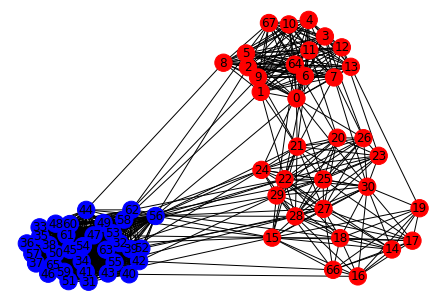

In [7]:
printgraph(getStrongAdjacencyMatrix(A) , algorithmeVershynin(getStrongAdjacencyMatrix(A)))

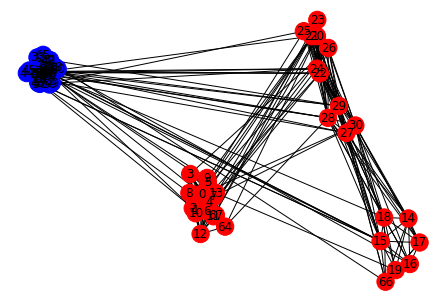

In [8]:
printgraph(A , algorithmeVershynin(A))

In [9]:
def getSubMatrix(M , label):
  a_eliminer = []
  for i in range(label.shape[0]):
    if label[i] == 1:
      a_eliminer.append(i)
  
  B = np.delete(M, a_eliminer , axis=0 )
  B = np.delete(B, a_eliminer , axis=1 )

  dico = {}
  count = 0
  for i in range(label.shape[0]):
    if label[i]:
      dico[count] = i
      count += 1
  return B , dico

B , dico  = getSubMatrix(A , algorithmeVershynin(A))

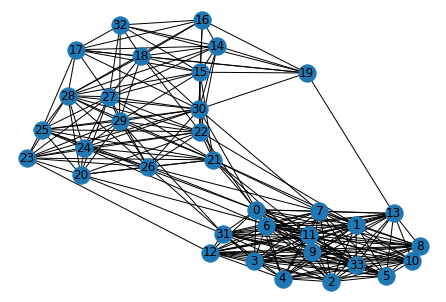

In [10]:
printgraph(getStrongAdjacencyMatrix(B))

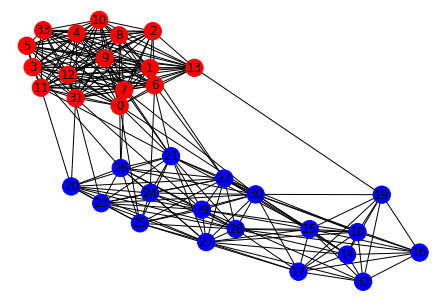

In [11]:
printgraph(getStrongAdjacencyMatrix(B) , algorithmeVershynin(B))

In [15]:
cluster_1 = []
cluster_2 = []
label = algorithmeVershynin(B)
for i in range(label.shape[0]):
  if label[i]:
    cluster_1.append(dico[i])
  else :
    cluster_2.append(dico[i])

label_list = label.argsort()
list(label_list)

[0,
 31,
 13,
 12,
 11,
 10,
 9,
 8,
 33,
 6,
 5,
 4,
 3,
 2,
 1,
 7,
 30,
 29,
 28,
 27,
 26,
 25,
 24,
 21,
 22,
 20,
 19,
 18,
 17,
 32,
 15,
 14,
 23,
 16]

In [13]:
cluster_3 = []
label = algorithmeVershynin(A)
for i in range(label.shape[0]):
  if label[i] == 0:
    cluster_3.append(i)

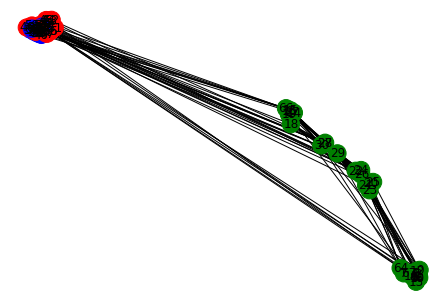

In [ ]:
def getColor():
  color = []
  for i in range(68):
    if i in cluster_1:
      color.append("red")
    elif i in cluster_2:
      color.append("blue")
    else:
      color.append("green")
  
  return color

def getPosition():
  pos = {}
  with open("/content/drive/MyDrive/Hackathon IA/Datasets/Brut Data/station.csv" , "r") as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
      if int(row[0]) in codToID:
        pos[codToID[int(row[0])]] = [-float(row[2]) , -float(row[3])]
  
  return pos

nx.drawing.nx_pylab.draw(nx.Graph(getStrongAdjacencyMatrix(A)), pos=getPosition(), node_color=getColor() , with_labels=True)

[-37.79728, 122.398436]
[-37.429082, 122.14280500000001]


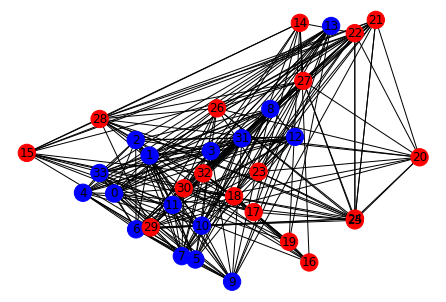

In [ ]:
colormap = []
for i in range(68):
  if i in cluster_1:
    colormap.append("red")
  if i in cluster_2:
    colormap.append("blue")

pos_bis = {}
pos = getPosition()
for i in range(len(cluster_1) + len(cluster_2)):
  pos_bis[i] = pos[dico[i]]

print(pos_bis[0])
print(pos[29])

nx.drawing.nx_pylab.draw(nx.Graph(getStrongAdjacencyMatrix(B)), pos=pos_bis, node_color=colormap , with_labels=True)

## *$k$-means* within bikeshare stations

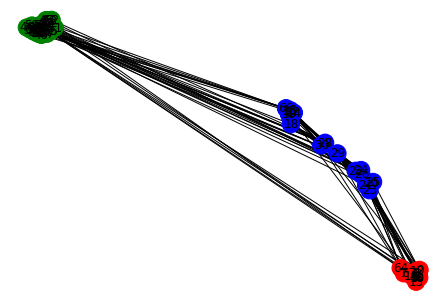

In [ ]:
from sklearn.cluster import KMeans

X = [pos[i] for i in range(68)]
X = np.array(X)

kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
label_k_means = kmeans.labels_
colormap_k_means = []

for i in range(68):
  if label_k_means[i] == 2:
    colormap_k_means.append("red")
  elif label_k_means[i] == 1:
    colormap_k_means.append("blue")
  else :
    colormap_k_means.append("green")
nx.drawing.nx_pylab.draw(nx.Graph(getStrongAdjacencyMatrix(A)), pos=getPosition(), node_color=colormap_k_means , with_labels=True)

In [ ]:
san_francisco = []
for a in cluster_1:
  san_francisco.append(a)
for a in cluster_2:
  san_francisco.append(a)
san_francisco


[45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 63,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 62,
 65]

In [ ]:
cluster_3

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 64,
 66,
 67]

## 2-dim embedding

In [ ]:
from keras.layers import Input, Dense, Embedding
from keras.models import Model, load_model, Sequential

def get2DEmbedding():
  model = Sequential()
  model.add(Input(shape = (2)))
  model.add(Embedding(68 , 2, input_length = 2))
  model.add(Dense(5, activation = "relu"))
  model.add(Dense(1 , activation = "sigmoid"))

  return model

model = get2DEmbedding()
model.compile(loss = "binary_crossentropy" , metrics = "accuracy" , optimizer="adam")
model.summary()
#model.save("/content/drive/MyDrive/Hackathon IA/Models/Data Mining/Embed2DModel")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2, 2)              136       
_________________________________________________________________
dense (Dense)                (None, 2, 5)              15        
_________________________________________________________________
dense_1 (Dense)              (None, 2, 1)              6         
Total params: 157
Trainable params: 157
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X = []
Y = []
with open("/content/drive/MyDrive/Hackathon IA/Datasets/Brut Data/trip.csv" , "r") as csvfile :
  csvreader = csv.reader(csvfile)
  next(csvreader)
  for row in csvreader:
    if int(row[4]) in codToID and int(row[7]) in codToID:
      X.append([codToID[int(row[4])] , codToID[int(row[7])]])
      Y.append(1)
      X.append([random.randint(0,67) , random.randint(0,67)])
      Y.append(0)

X = np.array(X)
Y = np.array(Y)

In [ ]:
model = load_model("/content/drive/MyDrive/Hackathon IA/Models/Data Mining/Embed2DModel")
#model.fit(X , Y, epochs = 100, batch_size=4096, verbose=2)

In [ ]:
#model.save("/content/drive/MyDrive/Hackathon IA/Models/Data Mining/Embed2DModel")

In [ ]:
pos_matrix = model.get_layer(index = 0).get_weights()[0]

In [ ]:
pos_embedding = {}
for i in range(68):
  pos_embedding[i] = pos_matrix[i][:]


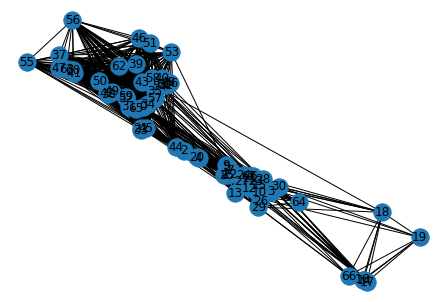

In [ ]:
nx.drawing.nx_pylab.draw(nx.Graph(getStrongAdjacencyMatrix(A)) , pos = pos_embedding , with_labels=True)

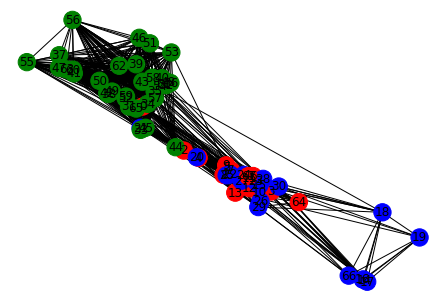

In [ ]:
nx.drawing.nx_pylab.draw(nx.Graph(getStrongAdjacencyMatrix(A)) , node_color=colormap_k_means, pos = pos_embedding , with_labels=True)

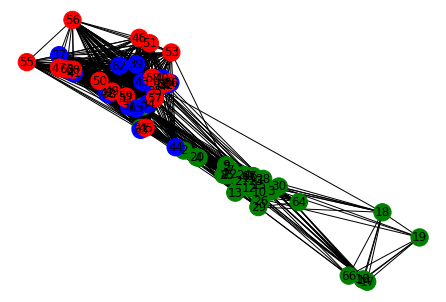

In [ ]:
nx.drawing.nx_pylab.draw(nx.Graph(getStrongAdjacencyMatrix(A)) , node_color=getColor(), pos = pos_embedding , with_labels=True)

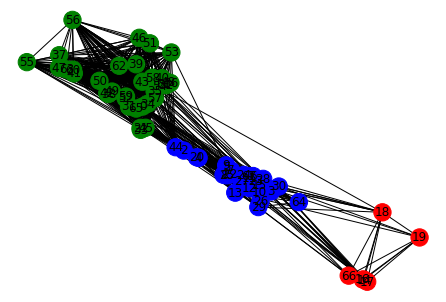

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(pos_matrix)
label_embedding = kmeans.labels_
colormap_embedding = []

for i in range(68):
  if label_embedding[i] == 2:
    colormap_embedding.append("red")
  elif label_embedding[i] == 1:
    colormap_embedding.append("blue")
  else :
    colormap_embedding.append("green")
nx.drawing.nx_pylab.draw(nx.Graph(getStrongAdjacencyMatrix(A)), pos=pos_embedding, node_color=colormap_embedding , with_labels=True)

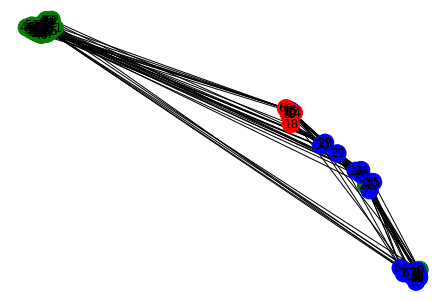

In [ ]:
nx.drawing.nx_pylab.draw(nx.Graph(getStrongAdjacencyMatrix(A)), pos=getPosition(), node_color=colormap_embedding , with_labels=True)

In [ ]:
new_station_pos = np.zeros(shape=(2))
new_station_pos[0] = 1/3*(pos[66][0] + pos[18][0] + pos[64][0])
new_station_pos[1] = 1/3*(pos[66][1] + pos[18][1] + pos[64][1])
print(new_station_pos)

[-37.44308  122.115085]


Il manque une station à Palo Alto !